In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import logging

import requests
from tqdm import tqdm, tqdm_notebook, trange

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.dvid import *
from neuclease.dvid.keyvalue import fetch_keyvalues
from neuclease.util import Timer, closest_approach
from neuclease.merge_table import normalize_recarray_inplace, generate_focused_assignment, generate_assignments
from neuclease.focused.ingest import *
from neuclease.focused.ingest import fetch_focused_decisions
from neuclease.focused.scores import calc_speculative_scores
from neuclease.focused.favorites import compute_favorites, mark_favorites, extract_favorites

In [3]:
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = [5, 5]

In [4]:
#import imp
#import neuclease.dvid.kafka
#imp.reload(neuclease.dvid.kafka)
#from neuclease.dvid.kafka import read_kafka_messages

In [5]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
#print("Cluster:")
#print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=46497749&submit_time=1536343895


In [6]:
root_logger = logging.getLogger()
root_logger.handlers = []
configure_default_logging()

In [7]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [8]:
sc

''

### UUIDS

In [9]:
# The starting agglo
initial_agglo_node = ('emdata3:8900', 'ac901')

# # The uuid used when loading the neo4j instance (for 'important bodies')
# neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# # The last supervoxel splits: One past the neo4j node
analysis_node = ('emdata3:8900', '662e')

# Current master
master_node = ('emdata3:8900', '7254')

### Analysis Node mapping

In [10]:
#msgs = read_kafka_messages(*analysis_node, 'segmentation', consumer_timeout=4.0)

In [12]:
analysis_mapping = fetch_complete_mappings(*analysis_node, 'segmentation')

INFO [2018-09-07 14:18:18,222] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 662e / segmentation
INFO [2018-09-07 14:18:51,014] Reading 911374 kafka messages took 32.79068660736084 seconds
INFO [2018-09-07 14:19:00,019] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...


KeyboardInterrupt: 

In [ ]:
#analysis_mapping = fetch_mappings(*analysis_node, 'segmentation')

In [ ]:
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

### Previous decisions

In [ ]:
%%time
LOAD_PREVIOUS_FROM_CSV = True
_path = f'focused-decisions-{master_node[1]}-2018-08-23.csv'

if LOAD_PREVIOUS_FROM_CSV:
    df = pd.read_csv(_path)
    df.fillna(0.0, inplace=True)
    df['sv_a'] = df['sv_a'].astype(np.uint64)
    df['sv_b'] = df['sv_b'].astype(np.uint64)
    df['body_a'] = df['body_a'].astype(np.uint64)
    df['body_b'] = df['body_b'].astype(np.uint64)
    previous_focused_decisions = df
else:
    previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                         normalize_pairs='sv')

    previous_focused_decisions.to_csv(_path, index=False, header=True)

# Body info is nearly useless because they correspond to the body ID
# at the time the edge was assigned -- not the current body ID.
# Let's delete the body columns to ensure we don't accidentally try to use it for anything.
del previous_focused_decisions['body_a']
del previous_focused_decisions['body_b']

previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

assert previous_focused_decisions.eval('id_a <= id_b').all()
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

In [ ]:
print(f"TOTAL decisions: {len(previous_focused_decisions)}")
merge_decisions = previous_focused_decisions.eval('result == "merge" or result == "mergeLater"').sum()
merge_rate = merge_decisions / len(previous_focused_decisions)
print(f"Merge(later) Decisions: {merge_decisions} ({100*merge_rate:.1f}%)")
previous_focused_decisions['result'].value_counts().plot(kind='pie')

In [ ]:
def drop_previously_reviewed(df, previous_focused_decisions_df):
    """
    Given a DataFrame of speculative focused decisions and 
    a DataFrame of previously reviewed focused decisions,
    drop all previous decisions from the speculative set,
    regardless of review results.
    """
    comparison_df = previous_focused_decisions_df[['id_a', 'id_b']].drop_duplicates()
    in_prev = df[['id_a', 'id_b']].merge(comparison_df,
                                         how='left',
                                         on=['id_a', 'id_b'],
                                         indicator='side')

    keep_rows = (in_prev['side'] == 'left_only')
    return df[keep_rows.values]

### Important bodies

In [ ]:
##
## Using Analysis node state!
##

#focused_bodies_path = 'focused-7254-2tbars-2psds-10.0Mv.npy'
focused_bodies_path = 'focused-662e-2tbars-2psds-10.0Mv.npy'
focused_bodies_table = pd.DataFrame(np.load(focused_bodies_path))
focused_bodies_table.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies_table.query('PreSyn >= 2 or PostSyn >= 10 or voxel_count >= 10e6', inplace=True)

important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

### Load/filter/score 2-hop tables

- load pre-updated tables (coords already fixed, supervoxels updated)
- normalize (`a<b`)
- filter
   - important TWO-HOP
   - non-merged
   - not yet reviewed
     - Note: this will toss out previously reviewed 'favorite' edges, meaning the next 'favorite' we pick below will be e.g. 2nd-favorite (if it survives the threshold).  Is that what we want?
- append scores

In [16]:
DROP_PREVIOUSLY_REVIEWED = False

#NODE = master_node
NODE = analysis_node

if NODE is master_node:
    filter_mapping = master_mapping
elif NODE is analysis_node:
    filter_mapping = analysis_mapping
else:
    assert False

if DROP_PREVIOUSLY_REVIEWED:
    TWOHOP_OUTPUT_DIR = f'twohop-tables-including-reviewed-{NODE[1]}'
else:
    TWOHOP_OUTPUT_DIR = f'twohop-tables-excluding-reviewed-{NODE[1]}'

os.makedirs(f'{TWOHOP_OUTPUT_DIR}/32nm', exist_ok=True)
os.makedirs(f'{TWOHOP_OUTPUT_DIR}/16nm', exist_ok=True)
os.makedirs(f'{TWOHOP_OUTPUT_DIR}/8nm', exist_ok=True)

previous_sv_values = previous_focused_decisions[['id_a', 'id_b']].values

driver_cwd = os.getcwd()


def apply_mapping_and_filter_to_partition(paths):
    print("init mapping...")
    # Must create mapper here since it cannot be pickled.
    filter_mapper = LabelMapper(filter_mapping.index.values, filter_mapping.values)

    # Compute once
    print("init sv pairs...")
    previous_sv_pairs = set(map(tuple, previous_sv_values))

    def apply_mapping_and_filter(npy_path):
        """
        Load the table from the given npy file,
        apply the body mapping, and remove rows with matching bodies.
        Also remove rows that correspond to decisions that have already been made.
        
        The resulting filtered table is stored in 'twohop-tables-*-reviewed-*/*nm/',
        (See TWOHOP_OUTPUT_DIR, above.)
        """
        print("loading table...")
        table = np.load(npy_path)
        df = pd.DataFrame(table)

        print("mapping bodies...")
        # A bug above caused the type to be int64. Fix that now.
        df['id_a'] = df['id_a'].astype(np.uint64, copy=False)
        df['id_b'] = df['id_b'].astype(np.uint64, copy=False)
        
        df['body_a'] = filter_mapper.apply(df['id_a'].values, allow_unmapped=True)
        df['body_b'] = filter_mapper.apply(df['id_b'].values, allow_unmapped=True)

        important_bodies, TWOHOP_OUTPUT_DIR # Referenced to ensure capture in this closure

        print("filtering out internal edges and compeltely unimportant edges...")
        # Drop internal edges,
        # Filter for important bodies (on at least one end -- capture 1-hop and 2-hop)
        q = '(body_a != body_b) and ((body_a in @important_bodies) or (body_b in @important_bodies))'
        df.query(q, inplace=True)

        print("normalizing...")
        table = df.to_records(index=False)
        normalize_recarray_inplace(table, 'id_a', 'id_b',
                                  ['id_a', 'body_a', 'xa', 'ya', 'za', 'caa', 'cba', 'da'],
                                  ['id_b', 'body_b', 'xb', 'yb', 'zb', 'cbb', 'cab', 'db'])

        df = pd.DataFrame(table)
        if DROP_PREVIOUSLY_REVIEWED:
            df = drop_previously_reviewed(df, previous_focused_decisions)
        
        print("appending scores...")
        df['score'] = calc_speculative_scores(df[['caa', 'cab', 'cba', 'cbb']].to_records(index=False))
        
        print("writing...")
        res = df['resolution'].iloc[0]
        fname = os.path.split(npy_path)[-1]
        output_path = f'{driver_cwd}/{TWOHOP_OUTPUT_DIR}/{res}nm/{fname}'
        np.save(output_path, df.to_records(index=False))

        return len(df)
    
    return list(map(apply_mapping_and_filter, paths))

In [17]:
# Test one first
#%time apply_mapping_and_filter_to_partition(['updated-tables/32nm/data-00000-of-00100.npy'])

In [18]:
filtered_totals = {}

for res in [32, 16, 8]:
    with Timer(f"Processing {res}nm..."):
        paths = map(os.path.abspath, glob.glob(f'updated-tables/{res}nm/data-*.npy'))
        filtered_totals[res] = sc.parallelize(paths).mapPartitions(apply_mapping_and_filter_to_partition).sum()
    
print(f"DONE. Total filtered edges: {sum(filtered_totals.values())}")

INFO [2018-08-30 15:00:19,762] Processing 32nm......
INFO [2018-08-30 15:02:07,719] Processing 32nm... took 0:01:47.956511
INFO [2018-08-30 15:02:07,721] Processing 16nm......
INFO [2018-08-30 15:04:28,941] Processing 16nm... took 0:02:21.219285
INFO [2018-08-30 15:04:28,942] Processing 8nm......
INFO [2018-08-30 15:07:28,096] Processing 8nm... took 0:02:59.153170
DONE. Total filtered edges: 906456099


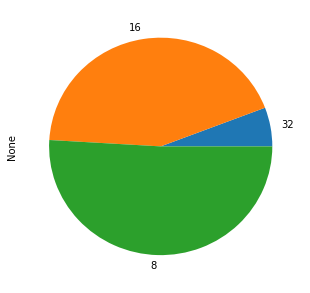

In [19]:
pd.Series(filtered_totals).plot(kind='pie')

### Select 1-hop edges

In [59]:
driver_cwd = os.getcwd()

#NODE = master_node
NODE = analysis_node

if DROP_PREVIOUSLY_REVIEWED:
    ONEHOP_OUTPUT_DIR = f'{driver_cwd}/onehop-tables-excluding-reviewed-{NODE[1]}'
else:
    ONEHOP_OUTPUT_DIR = f'{driver_cwd}/onehop-tables-including-reviewed-{NODE[1]}'
    
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/32nm', exist_ok=True)
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/16nm', exist_ok=True)
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/8nm', exist_ok=True)


def select_and_write_onehop(twohop_path):
    important_bodies # ref for pickle

    print("reading...")
    df = pd.DataFrame(np.load(twohop_path))
    res = df['resolution'].iloc[0]
    
    print("filtering for 1-hop edges...")
    q = 'body_a in @important_bodies and body_b in @important_bodies'
    df.query(q, inplace=True)
    
    print("writing...")
    fname = os.path.split(twohop_path)[-1]
    output_path = f'{ONEHOP_OUTPUT_DIR}/{res}nm/{fname}'
    np.save(output_path, df.to_records(index=False))
    return len(df)

NameError: name 'DROP_PREVIOUSLY_REVIEWED' is not defined

In [20]:
all_twohop_chunk_paths = map(os.path.abspath, glob.glob(f'{TWOHOP_OUTPUT_DIR}/*nm/*.npy'))
total_onehop_edges = sc.parallelize(all_twohop_chunk_paths).map(select_and_write_onehop).sum()
print(f"Selected {total_onehop_edges} one-hop edges")

Selected 233973009 one-hop edges


### Load into combined table

In [58]:
all_onehop_chunk_paths = glob.glob(f'{ONEHOP_OUTPUT_DIR}/*nm/*.npy')
all_onehop_chunks = list(map(np.load, tqdm_notebook(all_onehop_chunk_paths)))
combined_onehop_table = np.concatenate(all_onehop_chunks)
del all_onehop_chunks
print(f"Combined table is {combined_onehop_table.nbytes / 1e9:.1f} GB")

NameError: name 'ONEHOP_OUTPUT_DIR' is not defined

In [30]:
%time combined_onehop_df = pd.DataFrame(combined_onehop_table)

CPU times: user 1min 17s, sys: 1min 5s, total: 2min 22s
Wall time: 1min 5s


In [23]:
combined_onehop_df.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,cba,cbb,iou,da,db,resolution,body_a,body_b,score
0,1012359606,1135833306,16448,23743,15961,16401,23783,15924,0.982629,0.000000,0.001461,0.992530,0.000019,0.002408,0.000507,8,5813039957,1135828787,0.001461
1,1016749434,1016753364,10412,30574,14398,10406,30626,14399,0.986544,0.000000,0.000000,0.947968,0.000000,0.001237,0.002138,8,1016749259,1016749390,0.000000
2,1049662264,1049662419,27573,32595,14852,27513,32615,14878,0.991906,0.002317,0.000069,0.918828,0.000000,0.002363,0.003926,8,613175370,953154985,0.002317
3,1075054375,1167852620,12425,24956,16373,12436,24992,16339,0.777855,0.000000,0.000000,0.970840,0.000000,0.009229,0.000394,8,890191637,823058891,0.000000
4,1097365311,1097706148,23432,14451,15693,23444,14463,15684,0.994048,0.000359,0.000000,0.905296,0.000000,0.000107,0.000662,8,5813040784,973566036,0.000359


In [31]:
### Discard unneeded columns
#%time combined_onehop_df = combined_onehop_df[['id_a', 'id_b', 'body_a', 'body_b', 'score']].copy()

In [28]:
combined_onehop_df.memory_usage().sum() / 1e9

8.4230284040000001

In [29]:
combined_onehop_df.shape

(233973009, 5)

### Select decisions: All 1-hop

In [332]:
%%time
onehop_decisions = combined_onehop_df.merge(previous_focused_decisions[['id_a', 'id_b', 'result']],
                                            how='inner', on=['id_a', 'id_b'])

onehop_decisions.drop_duplicates(['id_a', 'id_b'], inplace=True)

onehop_decisions = onehop_decisions.merge(focused_bodies_table, how='left', left_on='body_a', right_index=True)
onehop_decisions = onehop_decisions.merge(focused_bodies_table, how='left', left_on='body_b', right_index=True,
                                          suffixes=['_a', '_b'])

PreSyn = np.sort(onehop_decisions[['PreSyn_a', 'PreSyn_b']].values, axis=1)
onehop_decisions['PreSyn_smaller'] = PreSyn[:,0]
onehop_decisions['PreSyn_larger'] = PreSyn[:,1]

PostSyn = np.sort(onehop_decisions[['PostSyn_a', 'PostSyn_b']].values, axis=1)
onehop_decisions['PostSyn_smaller'] = PostSyn[:,0]
onehop_decisions['PostSyn_larger'] = PostSyn[:,1]

onehop_decisions['TotalSyn_a'] = onehop_decisions['PreSyn_a'] + onehop_decisions['PostSyn_a']
onehop_decisions['TotalSyn_b'] = onehop_decisions['PreSyn_b'] + onehop_decisions['PostSyn_b']

TotalSyn = np.sort(onehop_decisions[['TotalSyn_a', 'TotalSyn_b']].values, axis=1)
onehop_decisions['TotalSyn_smaller'] = TotalSyn[:,0]
onehop_decisions['TotalSyn_larger'] = TotalSyn[:,1]

voxel_count = np.sort(onehop_decisions[['voxel_count_a', 'voxel_count_b']].values, axis=1)
onehop_decisions['voxel_count_smaller'] = voxel_count[:,0]
onehop_decisions['voxel_count_larger'] = voxel_count[:,1]

CPU times: user 2min 2s, sys: 58.2 s, total: 3min 1s
Wall time: 2min 19s


In [334]:
onehop_decisions.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,...,PreSyn_smaller,PreSyn_larger,PostSyn_smaller,PostSyn_larger,TotalSyn_a,TotalSyn_b,TotalSyn_smaller,TotalSyn_larger,voxel_count_smaller,voxel_count_larger
0,925872732,957243288,28384,33258,13167,28351,33288,13192,0.978906,0.728463,...,4,859,2,1492,6,2351,6,2351,2199647,1203227020
1,978215387,978216166,10726,20941,13865,10740,20910,13867,0.638316,0.164567,...,0,158,26,271,26,429,26,429,10656302,292079600
2,2180107316,2180452882,16954,10118,30845,16947,10081,30876,0.995444,0.786842,...,8,20,10,92,30,100,30,100,32865094,198468595
3,1590940221,1590940303,32150,10377,22590,32194,10354,22608,0.988324,0.998660,...,0,3,1,3,4,3,3,4,12787486,13097779
4,395252105,395252213,32997,28926,5666,32989,28922,5734,0.963968,0.293089,...,32,44,115,134,147,178,147,178,19781078,22731575



Decision ratio: 47.5%


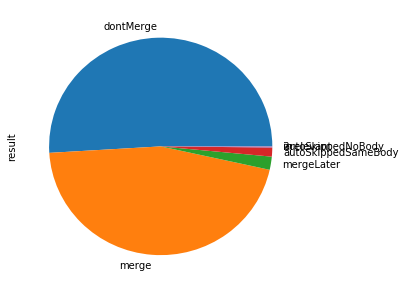

In [328]:
decision_counts = onehop_decisions['result'].value_counts()
decision_counts.plot(kind='pie')
ratio = (decision_counts['merge'] + decision_counts['mergeLater']) / decision_counts.sum()
print(f"\nDecision ratio: {100*ratio:.1f}%")


Scores (higher is better)


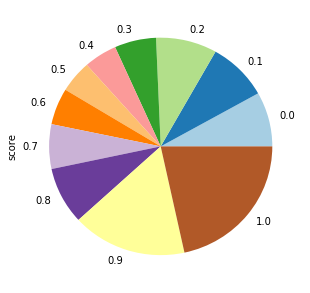

In [327]:
onehop_decisions['score'].apply(lambda s: f'{s:.1f}').value_counts()\
                         .sort_index().plot(kind='pie', colormap='Paired')
print("\nScores (higher is better)")

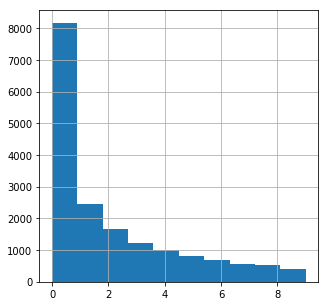

In [379]:
onehop_decisions.query('PreSyn_smaller < 2 and PostSyn_smaller < 10')['PostSyn_smaller'].hist()

In [405]:
new_counts = onehop_decisions.query('PreSyn_smaller < 2 and PostSyn_smaller >= 10')['result'].value_counts()
print(new_counts.sum())
(new_counts['merge'] + new_counts['mergeLater']) / new_counts.sum()

27116


0.41842454639327337

In [378]:
it1_ = onehop_decisions.query('PreSyn_smaller < 2 and PostSyn_smaller > 10')['result'].value_counts()


17521

### Plot

In [297]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [298]:
def show_merge_ratios(decisions_table, binned_column, bin_size, num_bins, show_ratio=False):
    bin_range = (0, bin_size*num_bins)

    merged_decisions = decisions_table.query('result == "merge" or result == "mergeLater"')
    merged_syncounts = merged_decisions[binned_column]
    merged_bincounts, merged_bins = np.histogram(merged_syncounts.values, num_bins, range=bin_range)

    notmerged_decisions = decisions_table.query('result == "dontMerge"')
    notmerged_syncounts = notmerged_decisions[binned_column]
    notmerged_bincounts, notmerged_bins = np.histogram(notmerged_syncounts.values, num_bins, range=bin_range)

    merged_data = merged_bincounts
    not_merged_data = notmerged_bincounts
    
    if show_ratio:
        merged_ratio = merged_bincounts / (merged_bincounts + notmerged_bincounts)
        notmerged_ratio = notmerged_bincounts / (merged_bincounts + notmerged_bincounts)

        merged_ratio = np.nan_to_num(merged_ratio)
        notmerged_ratio = np.nan_to_num(notmerged_ratio)
        
        merged_data = merged_ratio
        not_merged_data = notmerged_ratio

    label = {True: "Ratio", False: "Counts"}[show_ratio]
    p = figure( y_range=bin_range,
                plot_height=400,
                x_range=(-1.05*not_merged_data.max(), 1.05*merged_data.max()),
                title=f"(Don't) Merge {label} by {binned_column}",
                x_axis_label=f"Decision {label} (Don't Merge/Merge)",
                y_axis_label=f"{binned_column} (bin = {bin_size})")

    p.hbar((merged_bins[:-1] + merged_bins[1:])/2,
           bin_size*0.9,
           merged_data,
           0,
           color='navy')

    p.hbar((merged_bins[:-1] + merged_bins[1:])/2,
           bin_size*0.9,
           0,
           -not_merged_data,
           color='crimson')

    show(p)

In [335]:
show_ratio = False
show_merge_ratios(onehop_decisions, 'score', bin_size=0.1, num_bins=10, show_ratio=False)
show_merge_ratios(onehop_decisions, 'PreSyn_smaller', bin_size=1, num_bins=50, show_ratio=show_ratio)
show_merge_ratios(onehop_decisions, 'PreSyn_larger', bin_size=1, num_bins=50, show_ratio=show_ratio)
show_merge_ratios(onehop_decisions, 'PostSyn_smaller', bin_size=1, num_bins=50, show_ratio=show_ratio)
show_merge_ratios(onehop_decisions, 'TotalSyn_smaller', bin_size=1, num_bins=50, show_ratio=show_ratio)

### Select decisions: Iteration-1 only

In [ ]:
# Load all iteration 1 edges
it1_path = ('/nrs/flyem/bergs/final-agglo/speculative-iterations/'
         + 'final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy')

it1_table = np.load(it1_path)
normalize_recarray_inplace(it1_table, 'id_a', 'id_b', ['id_a', 'xa', 'ya', 'za'], ['id_b', 'xb', 'yb', 'zb'])
it1_df = pd.DataFrame(it1_table)

In [336]:
it1_decisions = onehop_decisions.merge(it1_df[['id_a', 'id_b']], how='inner', on=['id_a', 'id_b'])

In [337]:
it1_decisions.shape

(61780, 36)

In [338]:
it1_decisions.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,...,PreSyn_smaller,PreSyn_larger,PostSyn_smaller,PostSyn_larger,TotalSyn_a,TotalSyn_b,TotalSyn_smaller,TotalSyn_larger,voxel_count_smaller,voxel_count_larger
0,1046549486,1077588372,23783,28680,15010,23741,28640,15019,0.794859,0.000000,...,0,138,12,840,12,978,12,978,300394,335660312
1,977036712,977041157,29693,18867,13639,29680,18858,13608,0.946426,0.500000,...,4,6,1,3,7,7,7,7,2346289,12653438
2,1283276430,1407078886,28101,13397,19731,28123,13344,19716,0.953926,0.000000,...,0,37,10,178,215,10,10,215,191818,161820971
3,1234774536,1234778963,20549,31154,17365,20590,31165,17433,0.972158,0.795663,...,0,1209,15,15550,15,16759,15,16759,126216,3721970395
4,1624898168,1655932520,17446,14173,23217,17422,14175,23262,0.995802,0.989871,...,0,132,15,101,233,15,15,233,679760,141993284


In [369]:
it1_new_decisions = it1_decisions.query('PreSyn_smaller == 2')['result'].value_counts()
(it1_new_decisions['merge'] + it1_new_decisions['mergeLater']) / it1_new_decisions.sum()

0.85304193738924983

In [359]:
it1_new_decisions.sum()

6573

In [355]:
show_merge_ratios(it1_decisions.query('PreSyn_smaller < 2'),
                                      'PostSyn_smaller', bin_size=1, num_bins=20, show_ratio=False)

In [401]:
show_merge_ratios(it1_decisions, 'PreSyn_smaller', bin_size=1, num_bins=20, show_ratio=False)
show_merge_ratios(it1_decisions, 'PreSyn_smaller', bin_size=1, num_bins=20, show_ratio=True)
#show_merge_ratios(it1_decisions, 'PreSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

show_merge_ratios(it1_decisions, 'PostSyn_smaller', bin_size=1, num_bins=20, show_ratio=False)
show_merge_ratios(it1_decisions, 'PostSyn_smaller', bin_size=1, num_bins=20, show_ratio=True)
#show_merge_ratios(it1_decisions, 'PostSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

#show_merge_ratios(it1_decisions, 'TotalSyn_smaller', bin_size=1, num_bins=20, show_ratio=show_ratio)
#show_merge_ratios(it1_decisions, 'TotalSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

### Select decisions: Recent set only

In [56]:
recent_assignments = pd.read_csv('remaining-onehop-assignments-7254-20180823.csv')

In [57]:
recent_decisions = onehop_decisions.merge(recent_assignments[['id_a', 'id_b']], how='inner', on=['id_a', 'id_b'])

NameError: name 'onehop_decisions' is not defined

In [391]:
recent_decisions.shape

(73210, 36)

In [393]:
recent_counts = recent_decisions['result'].value_counts()
(recent_counts['merge'] + recent_counts['mergeLater']) / recent_counts.sum()

0.22182761917770796

In [417]:
q = ('(PreSyn_smaller < 2 and (PostSyn_smaller >= 10 or voxel_count_smaller >= 10e6))')
recent_decisions.query(q).shape

(26706, 36)

In [416]:
recent_decisions.query('PreSyn_smaller >= 2').shape

(42607, 36)

In [ ]:
recent_`adecisions.query('PreSyn_smaller >= 2 or PostSyn_smaller >= 10 or (voxel_count_smaller >= 10e6 and ').shape

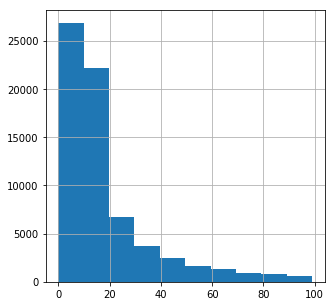

In [406]:
#recent_decisions.query('PostSyn_smaller < 100')['PostSyn_smaller'].hist()

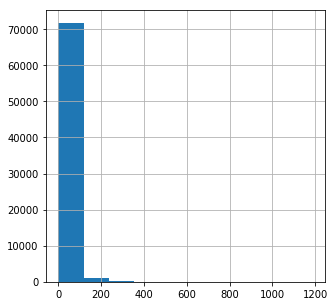

In [395]:
recent_decisions['PreSyn_smaller'].hist()

In [400]:
show_merge_ratios(recent_decisions, 'PreSyn_smaller', bin_size=1, num_bins=20, show_ratio=False)
show_merge_ratios(recent_decisions, 'PreSyn_smaller', bin_size=1, num_bins=20, show_ratio=True)
#show_merge_ratios(recent_decisions, 'PreSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

show_merge_ratios(recent_decisions, 'PostSyn_smaller', bin_size=1, num_bins=20, show_ratio=False)
show_merge_ratios(recent_decisions, 'PostSyn_smaller', bin_size=1, num_bins=20, show_ratio=True)
#show_merge_ratios(recent_decisions, 'PostSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

#show_merge_ratios(recent_decisions, 'TotalSyn_smaller', bin_size=1, num_bins=20, show_ratio=show_ratio)
#show_merge_ratios(recent_decisions, 'TotalSyn_larger', bin_size=1, num_bins=20, show_ratio=show_ratio)

In [418]:
recent_it1_decisions = recent_decisions.merge(it1_df[['id_a', 'id_b']], how='inner', on=['id_a', 'id_b'])

In [420]:
recent_it1_decisions.shape

(6050, 36)

In [423]:
ritc = recent_it1_decisions['result'].value_counts()
(ritc['merge'] + ritc['mergeLater']) / ritc.sum()

0.47719008264462809

### Recent, limited to 160k group (no "second-favorites")

In [ ]:
recent_no_second_favorites = load_focused_table('remaining-onehop-assignments-7254-20180824.csv')

In [ ]:
recent_no_second_favorites.head()

In [ ]:
recent_no_second_favorites['body_a'] = analysis_mapper.apply(recent_no_second_favorites['id_a'].values, True)
recent_no_second_favorites['body_b'] = analysis_mapper.apply(recent_no_second_favorites['id_b'].values, True)

In [ ]:
recent_no_second_favorites.head()

In [ ]:
# Remove previously reviewed
_merged = recent_no_second_favorites[['id_a', 'id_b']].merge(previous_focused_decisions[['id_a', 'id_b']],
                                                             how='left',
                                                             on=['id_a', 'id_b'],
                                                             indicator='source_table')
unreviewed_pos = (_merged['source_table'] == 'left_only')
recent_no_second_favorites_unreviewed = recent_no_second_favorites.loc[unreviewed_pos].copy()

In [ ]:
focused_bodies_table.head()

In [ ]:
# Remove edges between "old" bodies (i.e. 2 tbars on both sides.)
recent_no_second_favorites_unreviewed = recent_no_second_favorites_unreviewed.merge(focused_bodies_table,
                                            how='inner', left_on='body_a', right_index=True)
recent_no_second_favorites_unreviewed = recent_no_second_favorites_unreviewed.merge(focused_bodies_table,
                                            how='inner', left_on='body_b', right_index=True,
                                           suffixes=['_a', '_b'])

# Remove edges that involve two bodies that already had >= 2 t-bars
# (How did these make it into the set?)
filtered_table = recent_no_second_favorites_unreviewed.query('not (PreSyn_a >= 2 and PreSyn_b >= 2)')
#filtered_table.to_csv('remaining-onehop-assignments-7254-20180905.csv', index=False, header=True)

In [55]:
generate_assignments(filtered_table, 5000, 'remaining-onehop-assignments-7254-20180905')

100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


In [56]:
filtered_table.shape

(82561, 17)

### Decisions

In [55]:
recent_no_2nd_fav_decisions = recent_decisions.merge(recent_no_second_favorites[['id_a', 'id_b']],
                                                     how='inner', on=['id_a', 'id_b'])

NameError: name 'recent_decisions' is not defined

In [ ]:
rno2f = recent_no_2nd_fav_decisions['result'].value_counts()
(rno2f['merge'] + rno2f['mergeLater']) / rno2f.sum()

In [ ]:
recent_new_subset = recent_no_2nd_fav_decisions.query('PreSyn_a < 2 or PreSyn_b < 2')

In [ ]:
new_subset_counts = recent_new_subset['result'].value_counts()

In [ ]:
(new_subset_counts['merge'] + new_subset_counts['mergeLater']) / new_subset_counts.sum()

### Unrelated: Check tarsupervoxels status

In [14]:
master_focused_table = pd.DataFrame(np.load('focused-9e0d-2tbars-10psds-10.0Mv.npy'))
master_focused_table.head()

,body,voxel_count,sv_count,PostSyn,PreSyn
0,1497973422,12385573026,8953,8397,66
1,5813024096,10992947053,8172,7393,111
2,262840563,10492068511,6347,764,647
3,263199096,10129123402,2867,72,50
4,947573616,9261844618,7916,18638,4494


In [15]:
missing_svs = pd.read_csv('missing-focused-svs-9e0d.csv', dtype=np.uint64)

In [22]:
statuses = []
for start in trange(0, len(missing_svs), 10_000):
    sv_batch = missing_svs['sv'].iloc[start:start+10_000].values
    statuses.append( fetch_exists('emdata3:8900', '9e0d', 'segmentation_sv_meshes', sv_batch) )

100%|██████████| 15/15 [00:01<00:00,  8.62it/s]


In [25]:
missing_svs['exists'] = pd.concat(statuses).values

In [28]:
(~missing_svs['exists']).sum()

188

In [33]:
pd.Series(pd.unique(missing_svs.query('not exists and size > 100')['body']), name='body')\
  .to_csv('straggler-bodies-9e0d.csv')